## [E12] 트랜스포머로 만드는 대화형 챗봇

### 학습목표
------------
- 트랜스포머의 인코더 디코더 구조 이해하기
- 내부 단어 토크나이저 사용하기
- 셀프 어텐션 이해하기
- 한국어에도 적용해보기


### 참고 사이트
- 아이펠의 Exploration 12 노드
- [고려대학교 산업경영공학부 DSBA연구실|08-2:Transformer](https://www.youtube.com/watch?v=Yk1tV_cXMMU)
- [Positional Encoding in NLP](https://inmoonlight.github.io/2020/01/26/Positional-Encoding/)


-------------------
![](https://jalammar.github.io/images/t/the_transformer_3.png)
![](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)
![](https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.utils import plot_model
%matplotlib inline

## 1. 모델 구성
### 1-1. Positional encoding
단어를 임베딩 벡터로 변환하는 벡터화 과정을 거치는데, 트랜스포머의 경우는 임베딩하고 난 이후에 positional encoding을 임베딩 벡터에 더해준다.
- RNN은 단어를 문장에 위치하는 순서대로 입력되니까 따로 어순을 알려주지 않아도 되지만, __트랜스포머는 한꺼번에 모든 단어를 문장 단위로 입력하기 때문에 위치정보를 가진 벡터(positinal encoding)를 더해줘서 모델에 입력__ 해준다. 

- 좋은 Positional encoding scheme은 다음과 같은 두가지 특징을 갖고 있다. 
    1. 해당하는 encoding vector의 크기 자체는 동일해야한다.      
     - word embedding에 똑같은 크기로 더해줘야 동일한 벡터 크기가같은 벡터가 더해져서 모든 word들이 같은 방향 같은 크기로 변화한다는 보장을 할수 있다. 
    2. input sequence에 포함된 두 단어의 거리가 sequence 안에서 멀어지면, positional encoding vector 사이의 거리도 멀어져야 한다. 
    
    
- 여러가지 positional encoding vector가 있지만 "Attention is all you need"에서 사용된 PE(혹은 sinusoidal functions)는 sin, cos 함수를 사용하여서 만든다. 
- 

$$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


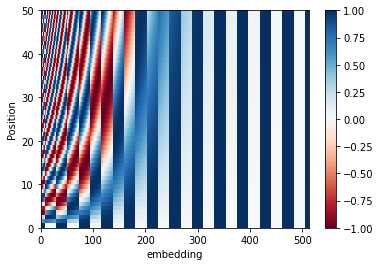

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.xlabel("embedding")
plt.colorbar()
plt.show()

### 1-2. Scaled Dot Product Attention

In [4]:
# scaled dot prodcut attention
def scaled_dot_product_attention(query, key, value, mask):
    # query vector와 key vector의 dot product
    matmul_qk = tf.matmul(query, key, transpose_b=True) 
    
    # 가중치를 정규화 
    # key의 dimension
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    # key의 dimension을 루트 씌워서  matmul_pk로 나눠준다.
    logits = matmul_qk / tf.math.sqrt(depth) 
    
    # 패딩에 마스크 추가
    # encoder에 넣을 때는 마스크 빼고, decoder에 넣을 때는 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕
    output = tf.matmul(attention_weights, value)
    return output


### 1-3. Multi - head Attention

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs


### 1-4. 패딩 마스킹 (padding masking)

- 패딩은 문장의 길이가 주어진 문장 길이보다 짧은 문장의 앞 혹은 뒤에 0으로 채워서 모든 문장의 길이를 동일하게 해주는 자연어 전처리이다.
- 패딩(0)처리가 된 위치를 표시하여 attention 연산을 실행할때 패딩을 포함 시키지 않는다. 그래서 padding masking 처리를 한다.

In [6]:
def create_padding_mask(x): # 패딩마스크
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 의미 없는 0
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [7]:
# 숫자가 0인 곳만 1이 되고 나머지는 0이 된다. 
# attention 연산할때 1인 부분을 제외하고 연산하게 함.
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### 1-5. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [8]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [9]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 1-6. 인코더
-  인코더 블록 및 인코더 생성     

In [10]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,'key': inputs,'value': inputs,'mask': padding_mask})
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [11]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model,
                                num_heads=num_heads,dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])
        return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 1-7. 디코더
-  디코더 블록 및 디코더 생성     

In [12]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,'key': inputs,'value': inputs,'mask': look_ahead_mask})
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,'key': enc_outputs,'value': enc_outputs,'mask': padding_mask})
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [13]:
def decoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


## 2. 챗봇 데이터(cornell movie dialogs Corpus) 로드 및 전처리

- 데이터 출처: [송영숙님 깃허브의 songys/Chatbot_data 레포지토리](https://github.com/songys/Chatbot_data)
- [다음카페- 사랑보다 아름다운 실연](https://cafe.daum.net/ilovedlove)에서 자주 나오는 이야기를 참고하여 제작한 챗봇 데이터셋

- 챗봇 트레이닝용 문답 페어 11,876개
- 레이블링 (0: 일상다반사/ 1: 이별(부정)/ 2: 사랑(긍정))


### 2.1 데이터 로드

In [14]:
dir_=os.getenv('HOME')+'/aiffel/transformer_chatbot/data' 
df=pd.read_csv(dir_+'/ChatbotData .csv',encoding='utf-8')

In [15]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


### 2.2 결측치, 중복된 데이터 제거 및  데이터 EDA   
- 다음 코드와 같이 결측치는 없다.

In [17]:
df.isnull().sum() # 결측치는 없음

Q        0
A        0
label    0
dtype: int64

중복된 데이터는 삭제한다.

In [18]:
df=df.drop_duplicates()

#### 각 레이블의 데이터 개수
- 0: 일상다반사, 1: 이별(부정), 2: 사랑(긍정)

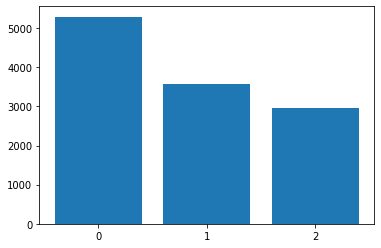

In [20]:
y=df["label"].value_counts()
x=y.index
plt.bar([0,1,2],y)
plt.xticks([0,1,2],x)
plt.show()

#### 각 레이블 별 데이터 확인

In [21]:
df.loc[df["label"]==0].head() # 일상적인 문답(사랑, 이별과 관련 없는 이야기)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [22]:
df.loc[df["label"]==1].head() # 이별관련 문답

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [23]:
df.loc[df["label"]==2].head() # 사랑 관련 문답

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


8860번의 짝사랑도 사랑이긴 하지만 긍정적인 사랑이야기라고는 생각하기 힘들다. 일단은 챗봇을 만들기 위한 데이터 관찰이므로 넘기지만 만일 감정분류를 할때 이 데이터를 사용한다면 주의해야할 것 같다.

In [25]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # (ㄱ-ㅣ가-힣,A-Z,a-z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣A-Za-z?.!,0-9]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


- 한국어 데이터에 대한 전처리를 해야하므로 영어 전처리 할때 알파벳과 문장부호만 남기고 공백으로 바꾸는 코드에 __ㄱ-l(자음,모음)과 가-힣(모든 한국어 글자)들을 제외__ 하는 정규표현식을 추가해주어야한다.

In [26]:
df["Q"]=df["Q"].map(lambda x: preprocess_sentence(x)) # 질문 전처리함수 적용
df["A"]=df["A"].map(lambda x: preprocess_sentence(x)) # 답변 전처리함수 적용

In [27]:
df.head()

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,PPL 심하네,눈살이 찌푸려지죠 .,0


### 불용어 제거
- [RANKS NL의 한국어 stop words](https://www.ranks.nl/stopwords/korean)를 참조하여서 불용어 리스트를 만들었다. 불용어를 제거하고자 한다.

In [28]:
def remove_stopwords(seq):
    stopwords=['아', '휴',"휴우", '아이구', '아이쿠', '아이고', '어', '나', '우리', 
               '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', 
               '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', 
               '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', 
               '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다',
               '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', 
               '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', 
               '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', 
               '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', 
               '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', 
               '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', 
               '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', 
               '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', 
               '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', 
               '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', 
               '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', 
               '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', 
               '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', 
               '그렇지않으면', '까악', '툭', '딱', '삐걱거리다', '보드득', '비걱거리다', '꽈당', '응당', 
               '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다', 
               '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', 
               '대하여', '관하여', '관한', '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', 
               '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에', '어찌', '하겠는가', 
               '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제', '야', '이봐', '어이', '여보시오', 
               '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸', '졸졸', 
               '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면', '혹은', 
               '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도', 
               '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼','어찌됏든', '그위에', '게다가', 
               '점에서 보아', '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', 
               '하게하다', '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여',
               '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', 
               '하자마자', '밖에 안된다', '하면된다', '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로',
               '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나',
               '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래', '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', 
               '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데', '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다\t하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면', '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것', '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다', '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']
    for i in seq:
        if i in stopwords:
            seq.pop(seq.index(i))
    return seq

- 불용어는 단어 단위이므로 일단 각 문장을 단어단위로 자른다.

In [29]:
# 각 문장을 띄어쓰기 단위로 자르기
df["Q_words"]=df["Q"].map(lambda x: x.split(" ")) 
df["A_words"]=df["A"].map(lambda x: x.split(" "))

- 불용어가 잘 삭제가 되는지 확인하기 위해서 질문에 불용어 "이젠"이 포함된 문장의 일부를 보자

In [30]:
df.loc[df["Q"].str.contains("이젠"),["Q_words","A_words"]].head()

,Q_words,A_words
3748,"[이젠, 기억이, 가물가물해]","[벌써, 그러면, 안돼요, .]"
3749,"[이젠, 기억이, 거의안나]","[벌써, 그러면, 안돼요, .]"
5629,"[그녀는, 내게, 돌아오지, 않아, 이젠, 잊어야해, .]","[마음을, 천천히, 보듬어, 주세요, .]"
6841,"[아무리, 기다려도, 이젠, 안돌아오나봐]","[그게, 끝이라면, 받아들여야, 해요, .]"
7137,"[오늘, 연락왔네, 그래도, 이젠, 안녕]","[정말, 안녕, .]"


In [31]:
# 질문과 답변의 불용어 제거하기
df["Q_words"]=df["Q_words"].map(lambda x: remove_stopwords(x))
df["A_words"]=df["A_words"].map(lambda x: remove_stopwords(x))

- Q_words컬럼에 불용어 '이젠'이 사라진 것을 확인할 수 있다.

In [32]:
df.loc[df["Q"].str.contains("이젠"),["Q_words","A_words"]].head()

,Q_words,A_words
3748,"[기억이, 가물가물해]","[벌써, 안돼요, .]"
3749,"[기억이, 거의안나]","[벌써, 안돼요, .]"
5629,"[그녀는, 내게, 돌아오지, 않아, 잊어야해, .]","[마음을, 천천히, 보듬어, 주세요, .]"
6841,"[아무리, 기다려도, 안돌아오나봐]","[그게, 끝이라면, 받아들여야, .]"
7137,"[오늘, 연락왔네, 이젠, 안녕]","[정말, 안녕, .]"


In [33]:
# 각 문장의 단어수
df["nQ"]=df["Q_words"].map(lambda x: len(x))
df["nA"]=df["A_words"].map(lambda x: len(x))

In [34]:
print("불용어 제거후 문장 길이가 0이 된 질문 데이터는 ",df.loc[df["nQ"]==0].shape[0],"개 이다.")
print("불용어 제거후 문장 길이가 0이 된 답변 데이터는 ",df.loc[df["nA"]==0].shape[0],"개 이다.")

불용어 제거후 문장 길이가 0이 된 질문 데이터는  8 개 이다.
불용어 제거후 문장 길이가 0이 된 답변 데이터는  5 개 이다.


In [35]:
s1=df.loc[df["nQ"]==0].index # 질문길이가 0이 된 문장의 인덱스
s2=df.loc[df["nA"]==0].index # 답변 길이가 0이 된 문장의 인덱스
# 질문길이가 0 혹은 답변길이가 0인 데이터의 인덱스
s=list(set(s1.tolist()) | set(s2.tolist()))
# 질문길이 혹은 답변 길이가 0인 데이터의 인덱스를 삭제하라
df=df.drop(s)


### 전처리한 질문과 답변을 문장으로 만든다.

In [36]:
questions=[" ".join(i) for i in df["Q_words"]]  
answers = [" ".join(i) for i in df["A_words"]]

In [37]:
df["Q"]=questions
df["A"]=answers

In [38]:
df.head()

,Q,A,label,Q_words,A_words,nQ,nA
0,12시 땡 !,하루가 가네요 .,0,"[12시, 땡, !]","[하루가, 가네요, .]",3,3
1,1지망 학교 떨어졌어,위로해 드립니다 .,0,"[1지망, 학교, 떨어졌어]","[위로해, 드립니다, .]",3,3
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",3,4
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 정도, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",4,4
4,PPL 심하네,눈살이 찌푸려지죠 .,0,"[PPL, 심하네]","[눈살이, 찌푸려지죠, .]",2,3


### 2-2. 단어장 만들기

In [39]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)


8106


In [40]:
# 정수 인코딩,
def tokenize(x):
        return START_TOKEN + tokenizer.encode(x) + END_TOKEN

# 최대 길이를 초과하는 샘플 제거, 패딩
# 최대 길이 9 이하인 경우에만 데이터셋으로 허용
def filter_(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    # 최대 길이 9으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    return tokenized_inputs, tokenized_outputs



In [41]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 22번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 22번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 22번째 질문 샘플: [5684, 593, 2434, 4103]
정수 인코딩 후의 22번째 답변 샘플: [7442, 7, 6193, 83, 1]


In [42]:
# 인코딩한 문답
df["Q_enc"]=df["Q"].map(lambda x: tokenize(x))
df["A_enc"]=df["A"].map(lambda x: tokenize(x))

#인코딩한 문답의 개수(시작,끝 토큰을 개수를 제외하기 위해서 -2를 한다)
df["nQ"]=df["Q_enc"].map(lambda x: len(x)-2)
df["nA"]=df["A_enc"].map(lambda x: len(x)-2)

In [43]:
df.head()

,Q,A,label,Q_words,A_words,nQ,nA,Q_enc,A_enc
0,12시 땡 !,하루가 가네요 .,0,"[12시, 땡, !]","[하루가, 가네요, .]",4,3,"[8104, 7843, 4143, 2993, 38, 8105]","[8104, 4670, 7822, 1, 8105]"
1,1지망 학교 떨어졌어,위로해 드립니다 .,0,"[1지망, 학교, 떨어졌어]","[위로해, 드립니다, .]",6,3,"[8104, 7897, 44, 875, 7880, 951, 1667, 8105]","[8104, 1771, 5428, 1, 8105]"
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",6,4,"[8104, 7899, 1392, 4587, 7880, 3582, 57, 8105]","[8104, 3331, 734, 118, 1, 8105]"
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0,"[3박4일, 정도, 놀러가고, 싶다]","[여행은, 언제나, 좋죠, .]",7,4,"[8104, 7899, 1392, 4587, 7880, 1257, 3582, 57,...","[8104, 3331, 734, 118, 1, 8105]"
4,PPL 심하네,눈살이 찌푸려지죠 .,0,"[PPL, 심하네]","[눈살이, 찌푸려지죠, .]",5,7,"[8104, 7928, 7928, 7924, 7880, 4127, 8105]","[8104, 839, 2235, 1451, 2126, 5397, 47, 1, 8105]"


### 문답 각각의 시퀀스의 단어수 분포(왼쪽:질문/ 오른쪽: 답)
- 최대 문장의 길이를 판단하기 위해서는 일단 __서브워드 텍스트 인코더(subword text encoder)로 토크나이즈를 해서 적절한 최대문장 길이를 생각해보자__ 
- 전체 데이터 분포 중에서 지나치게 긴 문장이 몇개 있다면 패딩이 너무 늘어나게 되어서 성능이 나빠진다.
- 최대 문장길이를 정하기 위해서 시퀀스의 단어수가 어떤 분포를 그리는지 체크해본다.

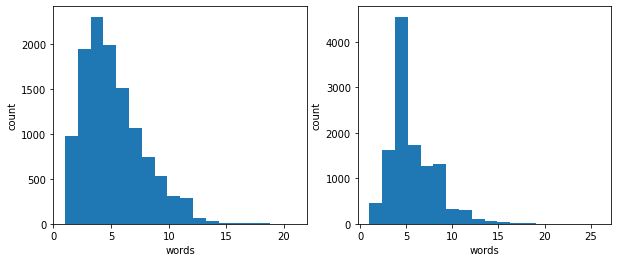

In [44]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["nQ"], bins=18)
plt.ylabel("count")
plt.xlabel("words")

plt.subplot(1,2,2)
plt.hist(df["nA"], bins=18)
plt.ylabel("count")
plt.xlabel("words")

plt.show()

In [45]:
print("전체 문장의 수:", df.shape[0])

전체 문장의 수: 11814


In [46]:
print("질문 문장중 가장 긴 단어수:",df["nQ"].max(),"/ 대답 문장 중 가장 긴 단어수:", df["nA"].max())
print("질문 문장중 가장 짧은 단어수:",df["nQ"].min(),"/ 대답 문장 중 가장 짧은 단어수:", df["nA"].min())

질문 문장중 가장 긴 단어수: 21 / 대답 문장 중 가장 긴 단어수: 26
질문 문장중 가장 짧은 단어수: 1 / 대답 문장 중 가장 짧은 단어수: 1


In [47]:
print("전체 질문 중 97%에 해당하는 문장이",np.percentile(df["nQ"].values, 97) ,"개 이하의 단어로 이루어져있다")
print("전체 답변 중 97%에 해당하는 문장이",np.percentile(df["nA"].values, 97) ,"개 이하의 단어로 이루어져있다")

전체 질문 중 97%에 해당하는 문장이 11.0 개 이하의 단어로 이루어져있다
전체 답변 중 97%에 해당하는 문장이 12.0 개 이하의 단어로 이루어져있다


In [48]:
print("질문문장 중에서 11단어 이하인 문장의 개수: ",df.loc[df["nQ"]<=11].shape[0],"/ 11단어를 초과하는 문장 개수:",df.loc[df["nQ"]>11].shape[0]) 
print("답변문장 중에서 12단어 이하인 문장의 개수: ",df.loc[df["nA"]<=12].shape[0],"/ 12단어를 초과하는 문장 개수:",df.loc[df["nA"]>12].shape[0]) 

질문문장 중에서 11단어 이하인 문장의 개수:  11575 / 11단어를 초과하는 문장 개수: 239
답변문장 중에서 12단어 이하인 문장의 개수:  11575 / 12단어를 초과하는 문장 개수: 239


- 최대 문장길이를 11로 정하면 전체 데이터 중에서 3%만 삭제하고 패딩 개수를 절반 가까이 줄일수 있기 때문에 일단 문장의 최대길이를 11로 정해볼수 있겠다.

In [49]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 11
print(MAX_LENGTH)

questions, answers=filter_(df["Q_enc"], df["A_enc"])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295


### 2-3. 교사강요(Teacher Forcing) 사용하기

In [50]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 3. 모델 정의 및 학습

### 3-1. 트랜스포머 정의

In [51]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)
    
    
    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


### 3-2. 손실함수
- 레이블이 문장이기 때문에 시퀀스에 패딩이 있다. 
- loss를 계산하기 위해서 패딩 마스크를 사용한다.

In [52]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)


### 3-3. 기본 모델 생성

In [53]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2602240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 3-4.Custom Learning rate Scheduling

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


- 커스텀 학습률 스케줄링 계획 시각화

Text(0.5, 0, 'Train Step')

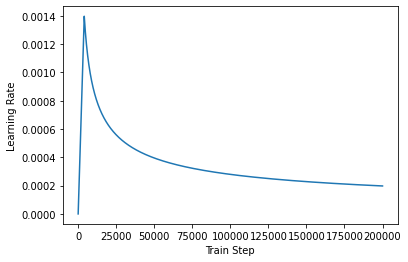

In [55]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 3-5. 기본 모델 컴파일

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


### 3-6. 기본모델 훈련하기(epoch= 50)
- epoch이 20일때 학습이 거의 이루어지지 않아서 50으로 늘려서 훈련을 일단 시켜보았다.

In [57]:
model_time={}

start = time.time()  # 시작 시간 저장

EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=0)

period=time.time() - start

model_time["model1"]=period

print("time :", period)

time : 194.51784873008728


## 4. 챗봇 테스트 하기

In [58]:
def decoder_inference(sentence, model):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

In [59]:
def sentence_generation(sentence, model):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence, model)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
    print("---"*20)
    
    return predicted_sentence


## 기본모델 도식화

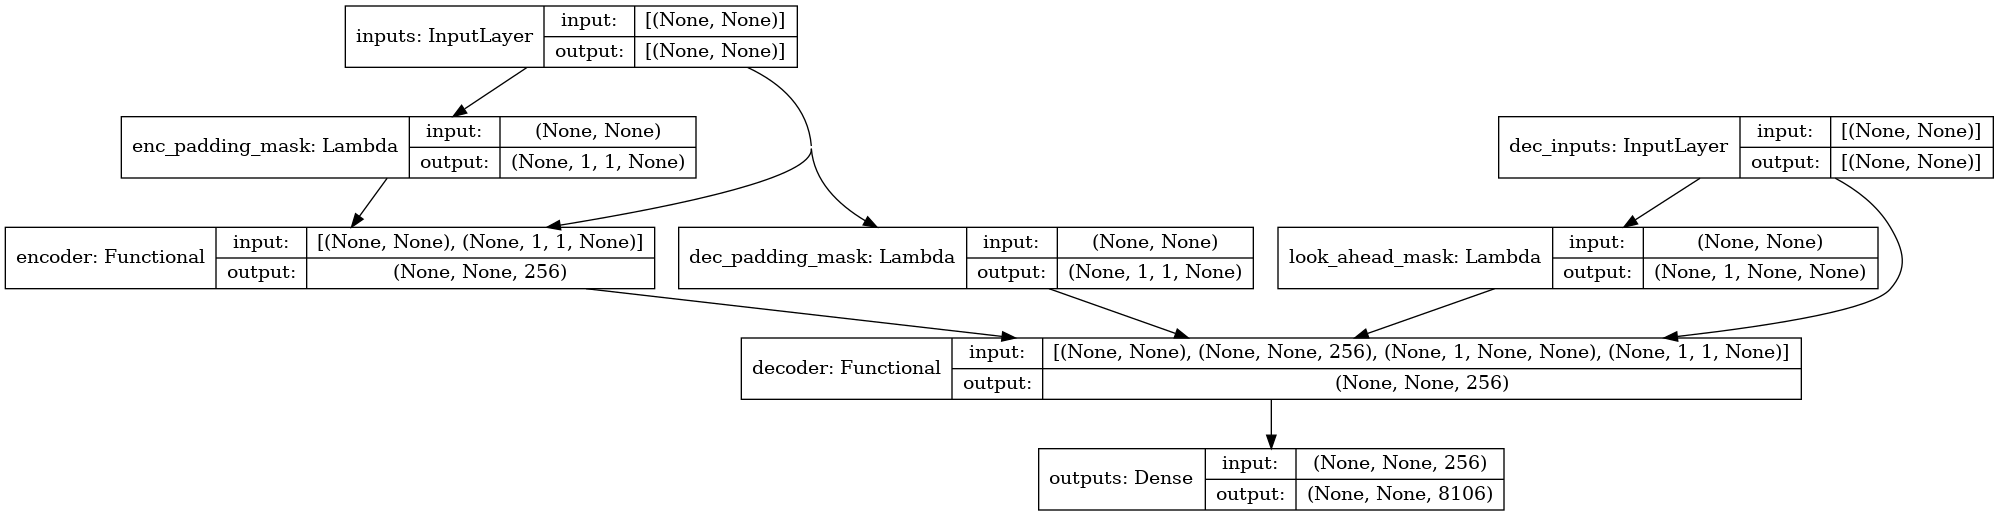

In [60]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

### 기본모델 learning curve 시각화

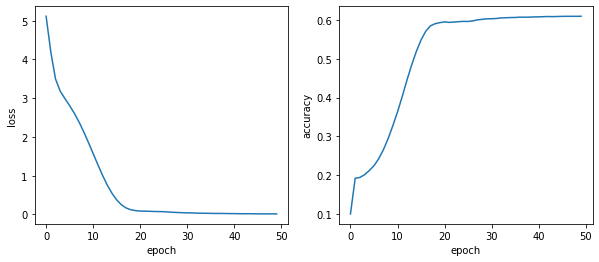

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(model.history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1,2,2)
plt.plot(model.history.history["accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

### 기본모델 대화 테스트

In [239]:
test_sentences=["피곤하다",
               "오늘 뭐 먹지?",
               "1년을 사귀었는데 헤어졌어",
               "남자친구가 연락이 없어",
               "살쪘어",
               "짝사랑 중이야",
               "회사가기 싫어",
               "놀러 가고 싶다",
               "그 사람이 싫어",
               "언제까지 어깨춤을 추게할꺼야",
               "아메리카노 마시고 싶다",
               "좋아하는 사람이 생겼어",
               "고백을 받았어"]
test_output=[sentence_generation(i,model) for i in test_sentences]

입력 : 피곤하다
출력 : 혼자가 아니에요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 오래 사귀셨네요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 제게 말씀해보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 가지 마세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 주소 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 마음이 헛헛한가봐요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 적당히 드세요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
-----------------------

In [240]:
test_df=pd.DataFrame(test_sentences,columns=["Q"])

test_df["pred1_A"]=test_output

In [241]:
test_df

,Q,pred1_A
0,피곤하다,혼자가 아니에요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,오래 사귀셨네요 .
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .
4,살쪘어,제게 말씀해보세요 .
5,짝사랑 중이야,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
6,회사가기 싫어,가지 마세요 .
7,놀러 가고 싶다,저도 주소 알려주세요 .
8,그 사람이 싫어,마음이 헛헛한가봐요 .
9,언제까지 어깨춤을 추게할꺼야,적당히 드세요 .


## 다양한 테스트를 하기 위해서 데이터셋 만드는 함수

In [65]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

def make_dataset(input_, output_,MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000):
    # 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이    
    print("최대문장 길이:",MAX_LENGTH)

    questions, answers=filter_(input_, output_)
    print('단어장의 크기 :',(VOCAB_SIZE))
    print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
    print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

    # 디코더는 이전의 target을 다음의 input으로 사용합니다.
    # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
    dataset = tf.data.Dataset.from_tensor_slices((
        {'inputs': questions,'dec_inputs': answers[:, :-1]},{'outputs': answers[:, 1:]},))
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# 모델 학습
def model_train(dataset, hyper_param):
    tf.keras.backend.clear_session()
    # 하이퍼파라미터
    NUM_LAYERS = hyper_param["NUM_LAYERS"]  # 인코더와 디코더의 층의 개수
    D_MODEL = hyper_param["D_MODEL"]     # 인코더와 디코더 내부의 입, 출력의 고정 차원
    NUM_HEADS = hyper_param["NUM_HEADS"]   # 멀티 헤드 어텐션에서의 헤드 수 
    UNITS =  hyper_param["UNITS"]      # 피드 포워드 신경망의 은닉층의 크기
    DROPOUT =  hyper_param["DROPOUT"]    # 드롭아웃의 비율
    EPOCHS =  hyper_param["EPOCHS"]
    
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)
    #model.summary()
    
    # 커스텀한 learning rate 스케쥴러
    learning_rate = CustomSchedule(D_MODEL)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
    # 학습
    model.fit(dataset, epochs=EPOCHS, verbose=0)
    return model

## 학습곡선 시각화
def draw_training_history(model_name, model):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model.history.history["loss"])
    plt.title("loss(%s)"%model_name)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.subplot(1,2,2)
    plt.plot(model.history.history["accuracy"])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy(%s)"%model_name)
    plt.show()

## 모델 2-1: 인코더 디코더의 블록 개수 4개

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295


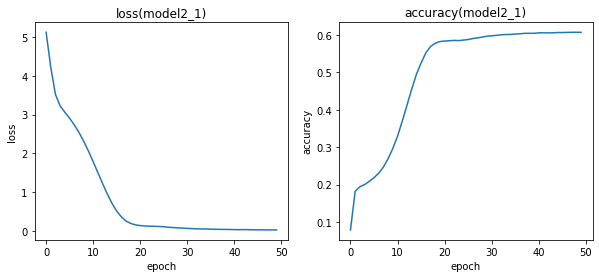

time : 273.5854609012604


In [176]:
start=time.time()
hyper_param2_1={"NUM_LAYERS":2*2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model2_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_1)

draw_training_history("model2_1",model2_1)

period=time.time() - start

model_time["model2_1"]=period

print("time :", period)

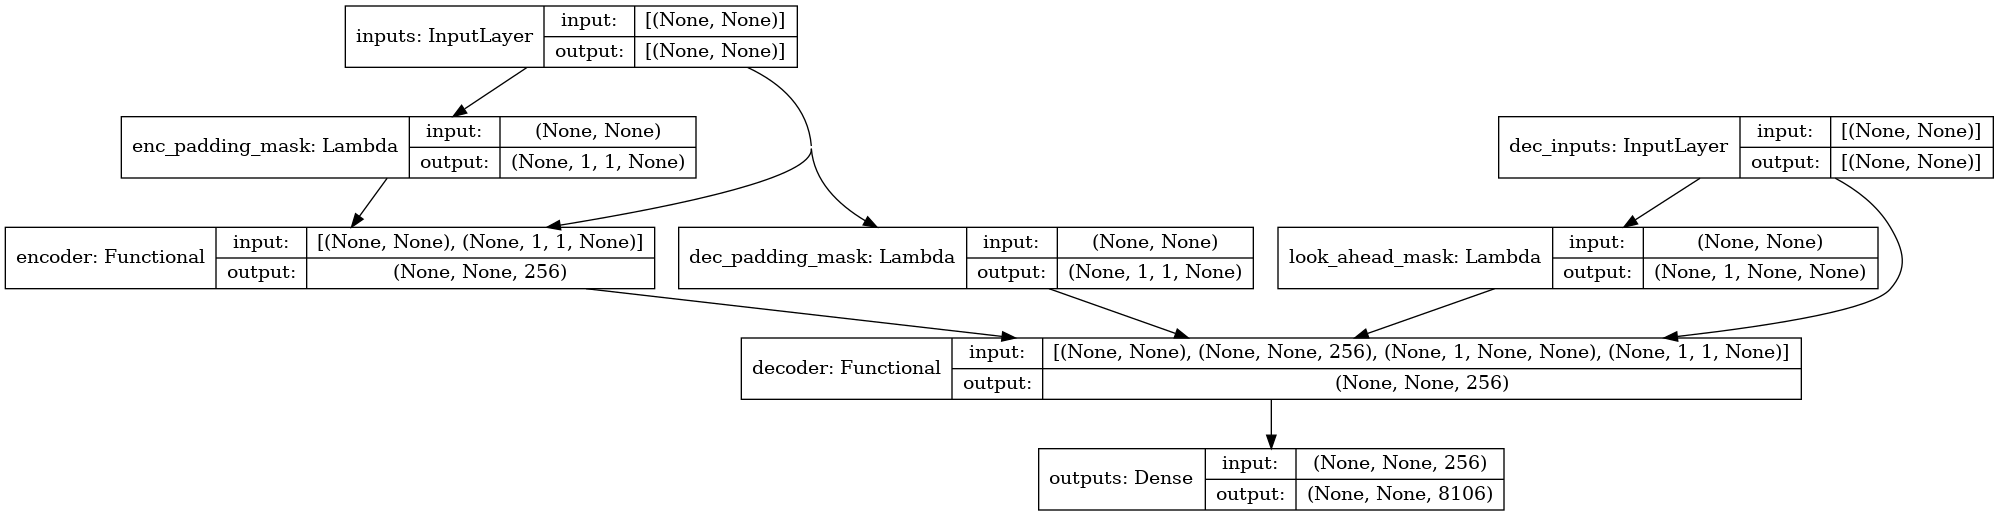

In [177]:
plot_model(model2_1, to_file='model2_1.png')
plot_model(model2_1, to_file='model2_1_shapes.png', show_shapes=True)


In [242]:
test_output2_1=[sentence_generation(i,model2_1) for i in test_sentences]
test_df["pred2_1_A"]=test_output2_1

입력 : 피곤하다
출력 : 아무 것도 안해도 괜찮아요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 오늘은 예능이요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 좋은 날들이 올 거예요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 뭘 하든 잘 찾아보세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 직접 물어보세요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 주소 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 자신을 탓하지 마세요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 좋은 보내고 있나봐요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
------------------

## 모델 2-2: Encoder & Decoder block 6개

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295


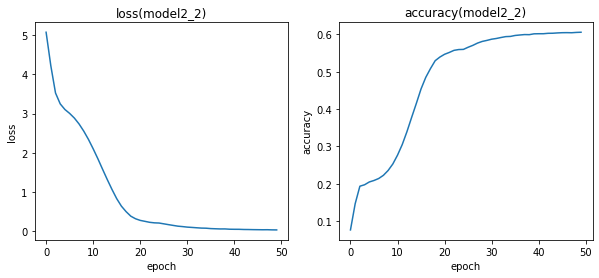

time : 375.0685884952545


In [70]:
hyper_param2_2={"NUM_LAYERS":2*3, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

start=time.time()
model2_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_2)

draw_training_history("model2_2",model2_2)

period=time.time() - start

model_time["model2_2"]=period

print("time :", period)

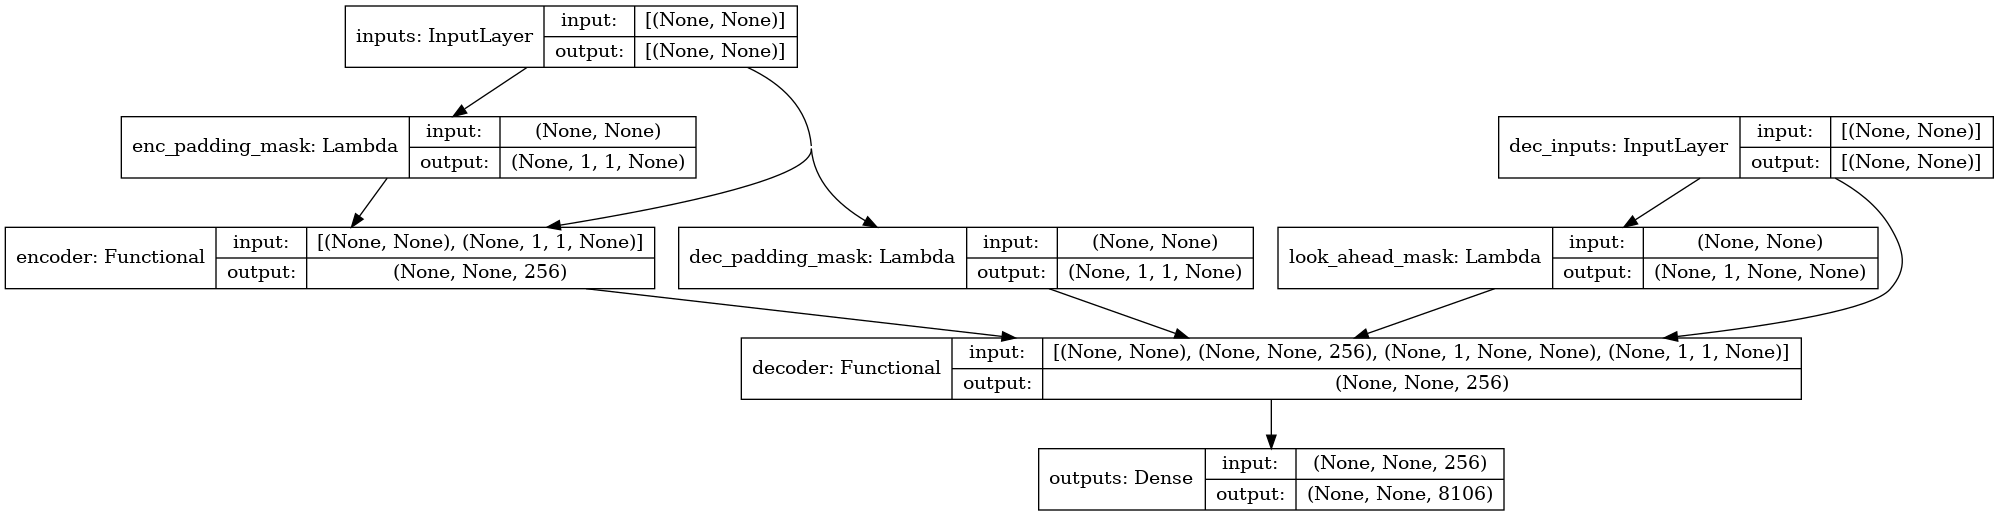

In [71]:
plot_model(model2_2, to_file='model2_2.png')
plot_model(model2_2, to_file='model2_2_shapes.png', show_shapes=True)


In [243]:
test_output2_2=[sentence_generation(i,model2_2) for i in test_sentences]
test_df["pred_2_2 A"]=test_output2_2

입력 : 피곤하다
출력 : 한가지만 게 몰라요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 고 만나는 지도 아닐 거예요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 뭘 힘들었고 있군요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 직접 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 제가 소 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 제가 괜찮아질 거예요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 그분에게 중요해요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
-------

## 모델 2-3: Encoder & Decoder block 8개

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 470.8617558479309


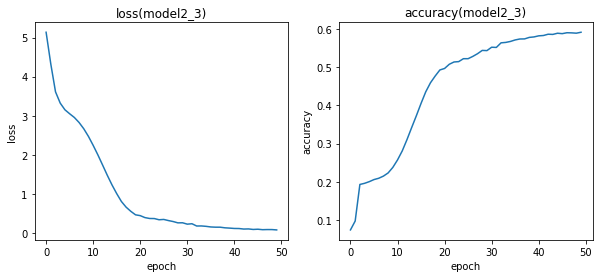

In [74]:
start=time.time()
hyper_param2_3={"NUM_LAYERS":2*4, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model2_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param2_3)


period=time.time() - start

model_time["model2_3"]=period

print("time :", period)

draw_training_history("model2_3",model2_3)

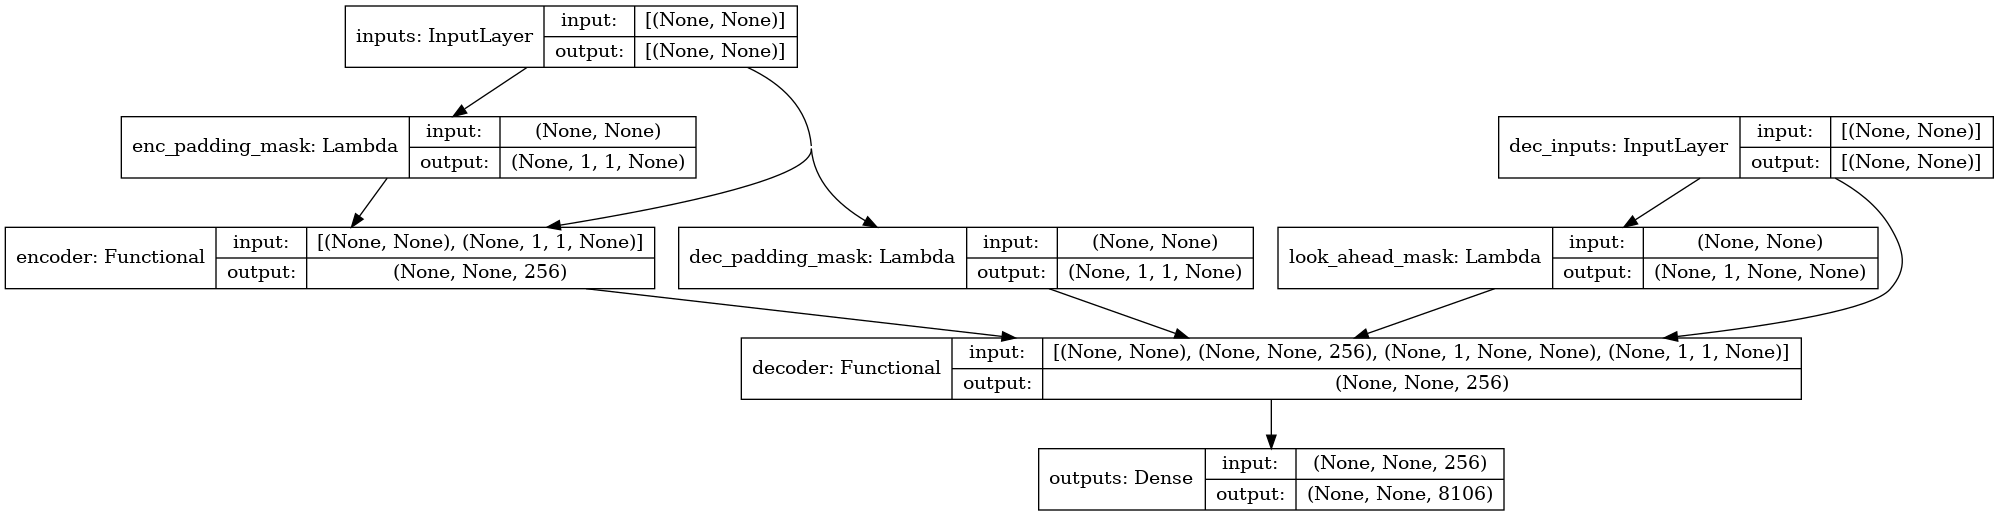

In [75]:
plot_model(model2_3, to_file='model2_3_shapes.png', show_shapes=True)

In [244]:
test_output2_3=[sentence_generation(i,model2_3) for i in test_sentences]
test_df["pred_2_3 A"]=test_output2_3

입력 : 피곤하다
출력 : 정말 잘 되길  .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 맛있는 다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 더 더 더 더 더 더 더 더 더 더 
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 요즘 한번쯤 시도해라고 볼 뿐이에요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도 
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 가족이 숨한 대해 좋을 같아요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 세상은 더 의고  .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 동사람에 열을 대해  .
------------------------------------------------------------
입력 :

## 모델 3-1: NUM_HEADS:16
- 가장 기본모델의 대답이 적절한 답처럼 보여서 기본 모델인 2층을 선택하기로 했다.
- 멀티 헤드 어텐션의 헤드 개수를 지금 8개에서 2배 늘린 16개로 조정해서 돌려보기로 했다.

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 191.8471963405609


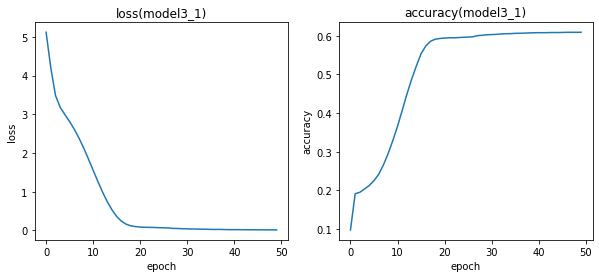

In [191]:
start=time.time()
hyper_param3_1={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*2, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_1)


period=time.time() - start

model_time["model3_1"]=period

print("time :", period)

draw_training_history("model3_1",model3_1)

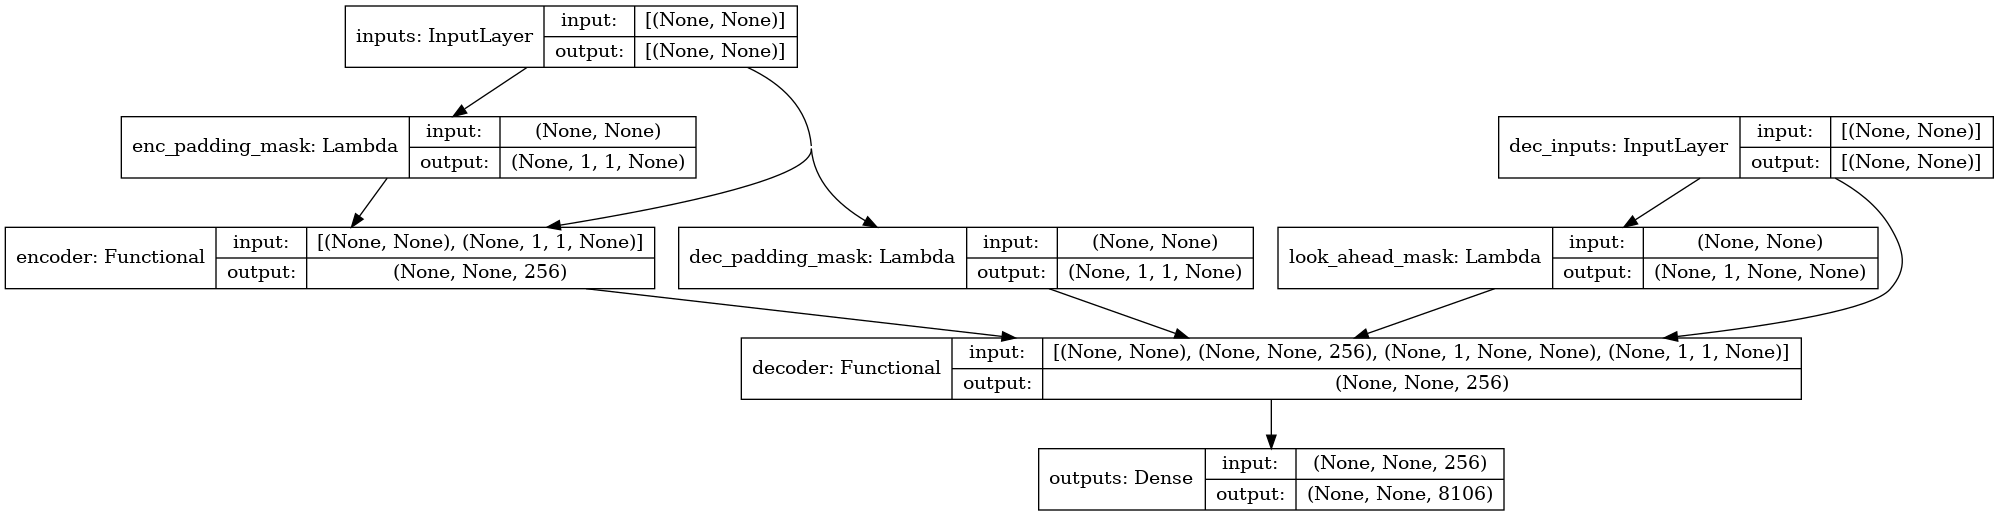

In [192]:
plot_model(model3_1, to_file='model3_1_shapes.png', show_shapes=True)

In [245]:
test_output3_1=[sentence_generation(i,model3_1) for i in test_sentences]
test_df["pred_3_1 A"]=test_output3_1

입력 : 피곤하다
출력 : 서로 이해하고 배려해보세요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 좋은 날들이 올 거예요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 항상 청결하게 관리하세요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 운명일지도 모르겠어요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 주기 어려울 거 같아요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 사랑은 변하고 사람은 안 변해요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 얼떨할 거예요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 

## 모델 3-2: NUM_HEADS:32


최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 200.26324105262756


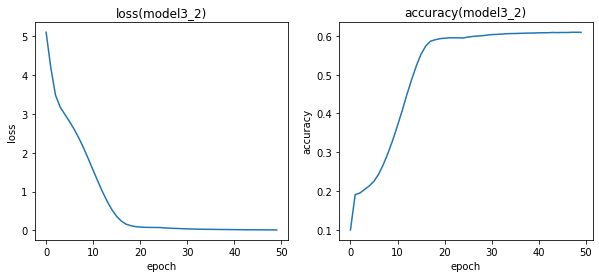

In [196]:
start=time.time()
hyper_param3_2={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*4, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_2)


period=time.time() - start

model_time["model3_2"]=period

print("time :", period)

draw_training_history("model3_2",model3_2)

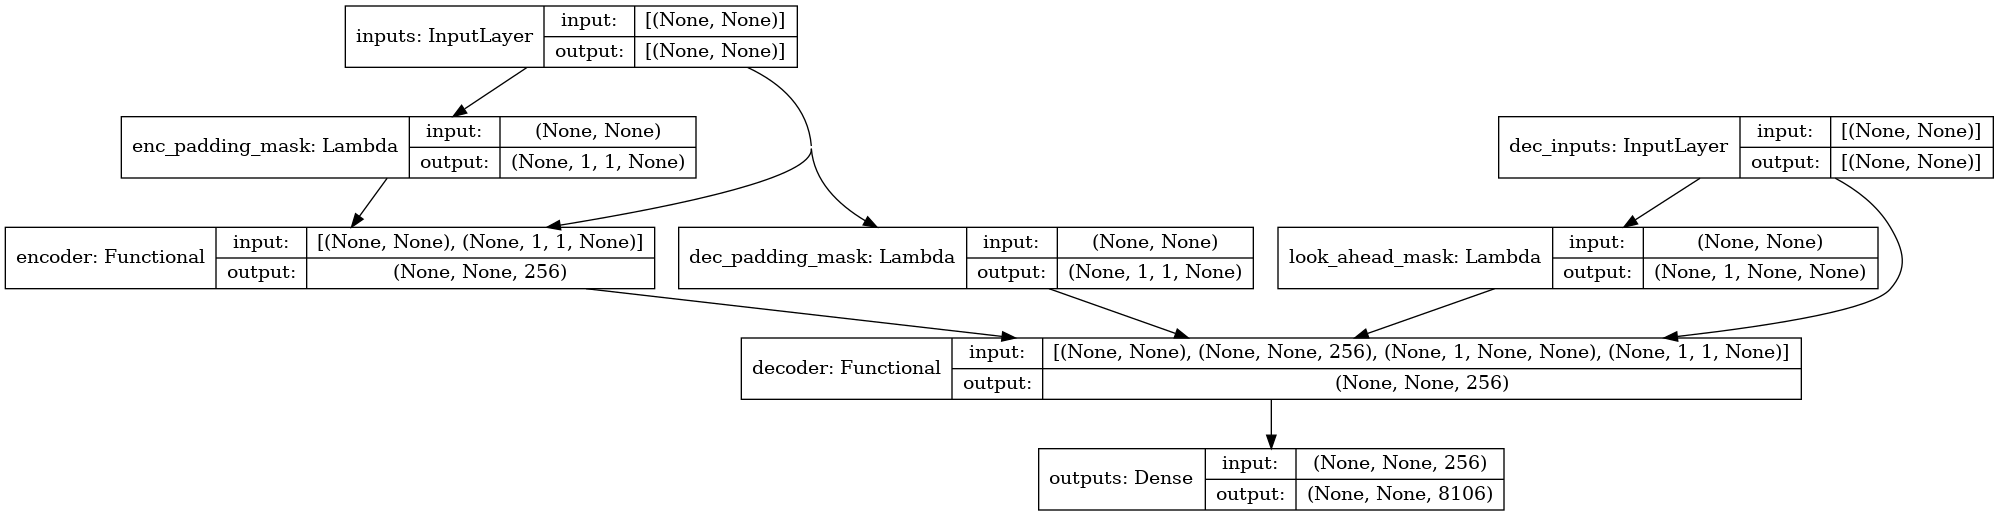

In [197]:
plot_model(model3_2, to_file='model3_2_shapes.png', show_shapes=True)

In [246]:
test_output3_2=[sentence_generation(i,model3_2) for i in test_sentences]
test_df["pred_3_2 A"]=test_output3_2

입력 : 피곤하다
출력 : 좋은 선택이길 바랄게요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 만나보세요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 식단조절을 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 내가 결혼할 때가 결혼적령기예요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 주당이에요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 제가 고민을 들어드릴게요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 생길거라 믿어요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
-----------

## 모델 3-3:  NUM_HEADS:48

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 223.37795114517212


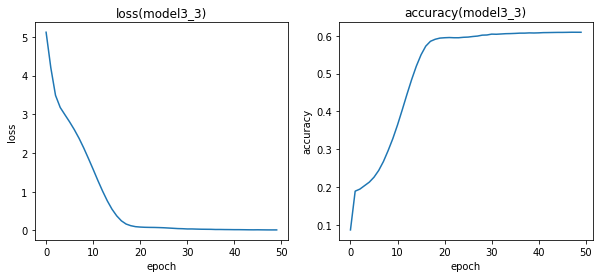

In [212]:
start=time.time()
hyper_param3_3={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8*8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model3_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 64,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param3_3)


period=time.time() - start

model_time["model3_3"]=period

print("time :", period)

draw_training_history("model3_3",model3_3)

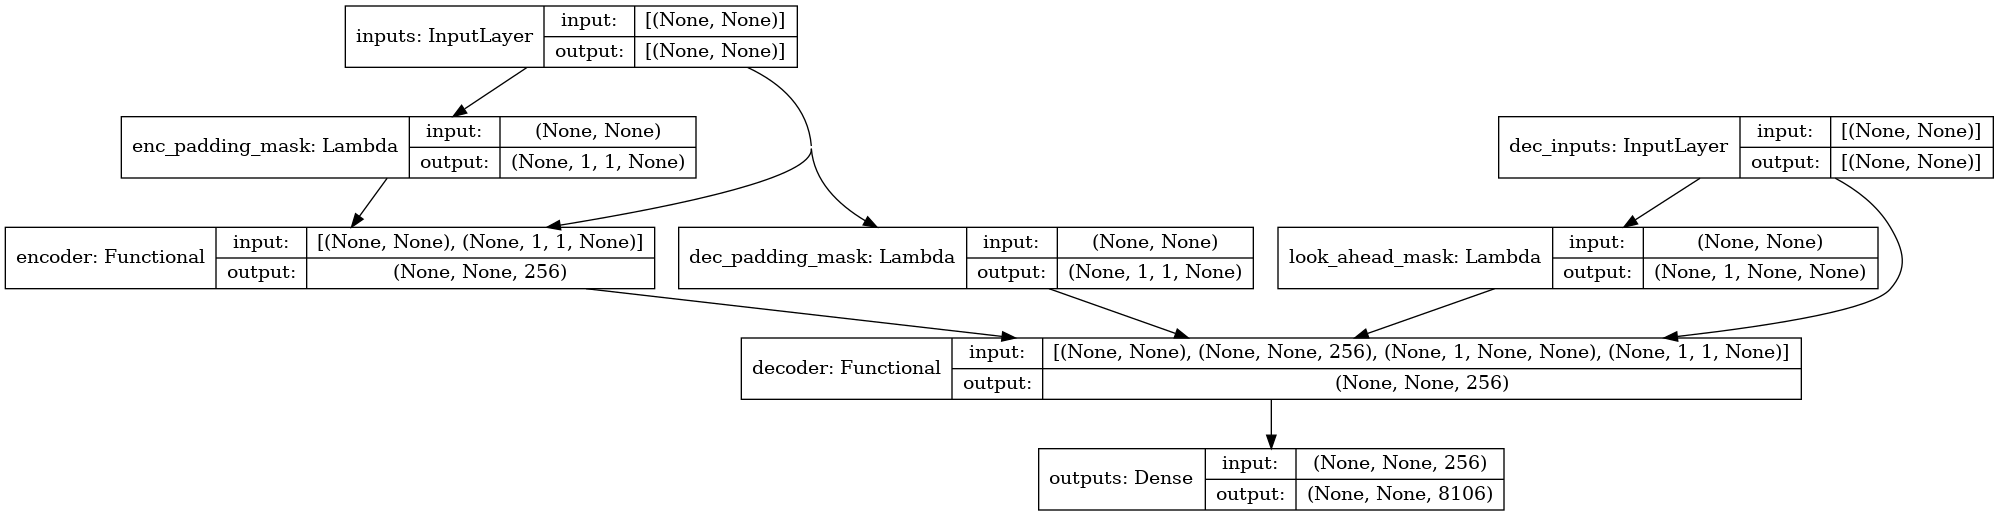

In [213]:
plot_model(model3_3, to_file='model3_3_shapes.png', show_shapes=True)

In [247]:
test_output3_3=[sentence_generation(i,model3_3) for i in test_sentences]
test_df["pred_3_3 A"]=test_output3_3

입력 : 피곤하다
출력 : 살랑살랑 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 좋은 날들이 올 거예요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 식단조절을 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 그것이 최선의 선택일거라 생각해요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 데려가 주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 싫어하지 말아요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 오래오래 입으세요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
--------------

## 모델 4-1

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 145.92600417137146


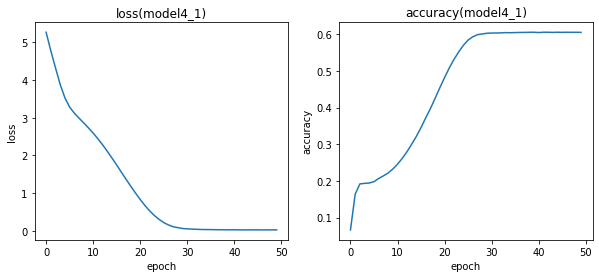

In [227]:
start=time.time()
hyper_param4_1={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*2, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_1 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_1)


period=time.time() - start

model_time["model4_1"]=period

print("time :", period)

draw_training_history("model4_1",model4_1)

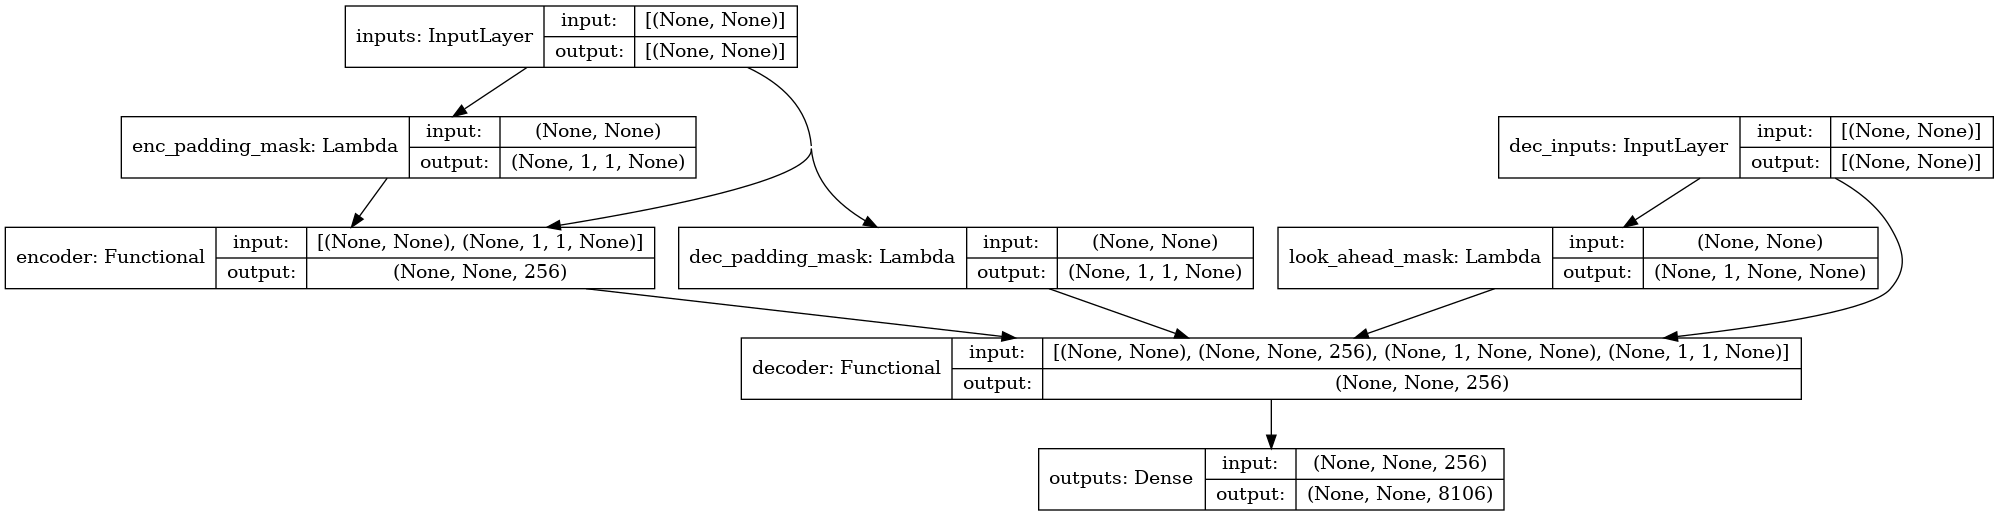

In [228]:
plot_model(model4_1, to_file='model4_1_shapes.png', show_shapes=True)

In [248]:
test_output4_1=[sentence_generation(i,model4_1) for i in test_sentences]
test_df["pred_4_1 A"]=test_output4_1

입력 : 피곤하다
출력 : 기다리면서 상처받지 마세요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 연락을 해보는 건 어떨까요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 뭘 입어도 멋져요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 저도 데려가 주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 제가 있잖아요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 사랑한 관계가 나아지지 않는다면 지칠지도 모르겠어요 .
------------------------------------------------------------
입력 : 아메리카노 마

## 모델 4-2

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 154.78830480575562


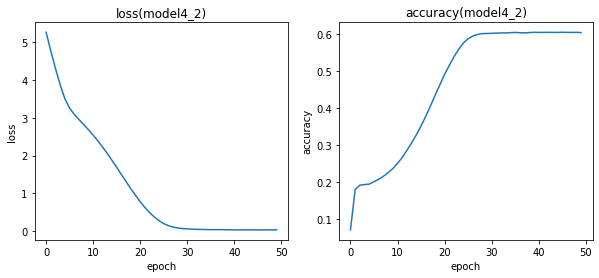

In [258]:
start=time.time()
hyper_param4_2={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*4, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_2 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_2)


period=time.time() - start

model_time["model4_2"]=period

print("time :", period)

draw_training_history("model4_2",model4_2)

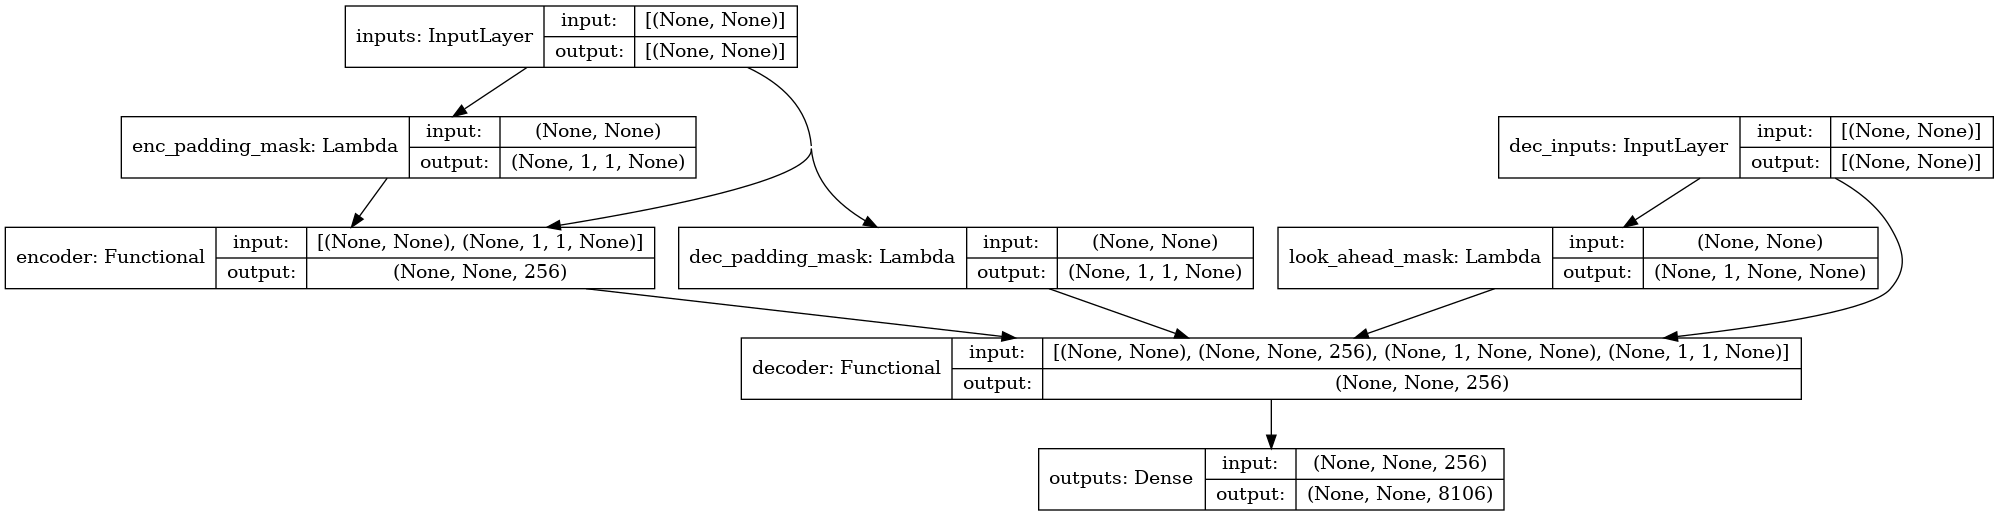

In [259]:
plot_model(model4_2, to_file='model4_2_shapes.png', show_shapes=True)

In [260]:
test_output4_2=[sentence_generation(i,model4_2) for i in test_sentences]
test_df["pred_4_2 A"]=test_output4_2

입력 : 피곤하다
출력 : 이별이 좋은 친구를 뒀네요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 더 오래 살아야 하니 가치관이 중요하겠어요 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 신기하네요 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 우울한 이유에 대해 생각해보세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 주소 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 슬픈 이야기네요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 자신의 건강만큼 쉬어야 할 같아요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시

In [261]:
test_df

,Q,pred1_A,pred2_1_A,pred_2_2 A,pred_2_3 A,pred_3_1 A,pred_3_2 A,pred_3_3 A,pred_4_1 A,pred_4_2 A
0,피곤하다,혼자가 아니에요 .,아무 것도 안해도 괜찮아요 .,한가지만 게 몰라요 .,정말 잘 되길 .,서로 이해하고 배려해보세요 .,좋은 선택이길 바랄게요 .,살랑살랑 .,기다리면서 상처받지 마세요 .,이별이 좋은 친구를 뒀네요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .,오늘은 예능이요 .,색다른걸 드셔보세요 .,맛있는 다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,오래 사귀셨네요 .,더 좋은 날들이 올 거예요 .,더 고 만나는 지도 아닐 거예요 .,더 더 더 더 더 더 더 더 더 더 더,더 좋은 날들이 올 거예요 .,먼저 만나보세요 .,더 좋은 날들이 올 거예요 .,먼저 연락을 해보는 건 어떨까요 .,더 오래 살아야 하니 가치관이 중요하겠어요 .
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .
4,살쪘어,제게 말씀해보세요 .,뭘 하든 잘 찾아보세요 .,뭘 힘들었고 있군요 .,요즘 한번쯤 시도해라고 볼 뿐이에요 .,항상 청결하게 관리하세요 .,식단조절을 .,식단조절을 .,뭘 입어도 멋져요 .,신기하네요 .
5,짝사랑 중이야,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,직접 물어보세요 .,진정으로 사랑한다면 직접 알아볼거예요 .,진정으로 사랑한다면 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .
6,회사가기 싫어,가지 마세요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .,가족이 숨한 대해 좋을 같아요 .,운명일지도 모르겠어요 .,내가 결혼할 때가 결혼적령기예요 .,그것이 최선의 선택일거라 생각해요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .
7,놀러 가고 싶다,저도 주소 알려주세요 .,주소 알려주세요 .,제가 소 알려주세요 .,저도 알려주세요 .,저도 주기 어려울 거 같아요 .,저도 주당이에요 .,저도 데려가 주세요 .,저도 데려가 주세요 .,주소 알려주세요 .
8,그 사람이 싫어,마음이 헛헛한가봐요 .,자신을 탓하지 마세요 .,제가 괜찮아질 거예요 .,세상은 더 의고 .,사랑은 변하고 사람은 안 변해요 .,제가 고민을 들어드릴게요 .,싫어하지 말아요 .,제가 있잖아요 .,슬픈 이야기네요 .
9,언제까지 어깨춤을 추게할꺼야,적당히 드세요 .,좋은 보내고 있나봐요 .,그분에게 중요해요 .,동사람에 열을 대해 .,얼떨할 거예요 .,생길거라 믿어요 .,오래오래 입으세요 .,사랑한 관계가 나아지지 않는다면 지칠지도 모르겠어요 .,자신의 건강만큼 쉬어야 할 같아요 .


## 모델 4-3

최대문장 길이: 11
단어장의 크기 : 8106
필터링 후의 질문 샘플 개수: 10295
필터링 후의 답변 샘플 개수: 10295
time : 181.3841769695282


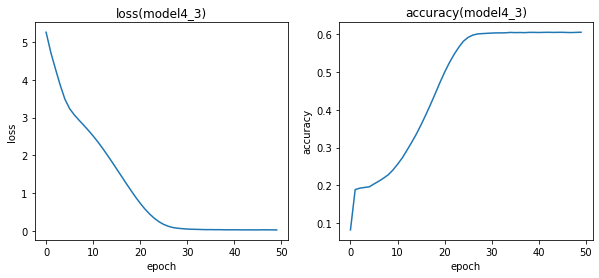

In [262]:
start=time.time()
hyper_param4_3={"NUM_LAYERS":2, # 인코더와 디코더의 층의 개수
             "D_MODEL": 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
             "NUM_HEADS":8, # 멀티 헤드 어텐션에서의 헤드 수 
             "UNITS":512*8, # 피드 포워드 신경망의 은닉층의 크기
             "DROPOUT":0.1, # 드롭아웃의 비율
             "EPOCHS":50} # epoch

model4_3 = model_train(make_dataset(df["Q_enc"],df["A_enc"],MAX_LENGTH = 11,BATCH_SIZE = 128,BUFFER_SIZE = 12000), 
                     hyper_param=hyper_param4_3)


period=time.time() - start

model_time["model4_3"]=period

print("time :", period)

draw_training_history("model4_3",model4_3)

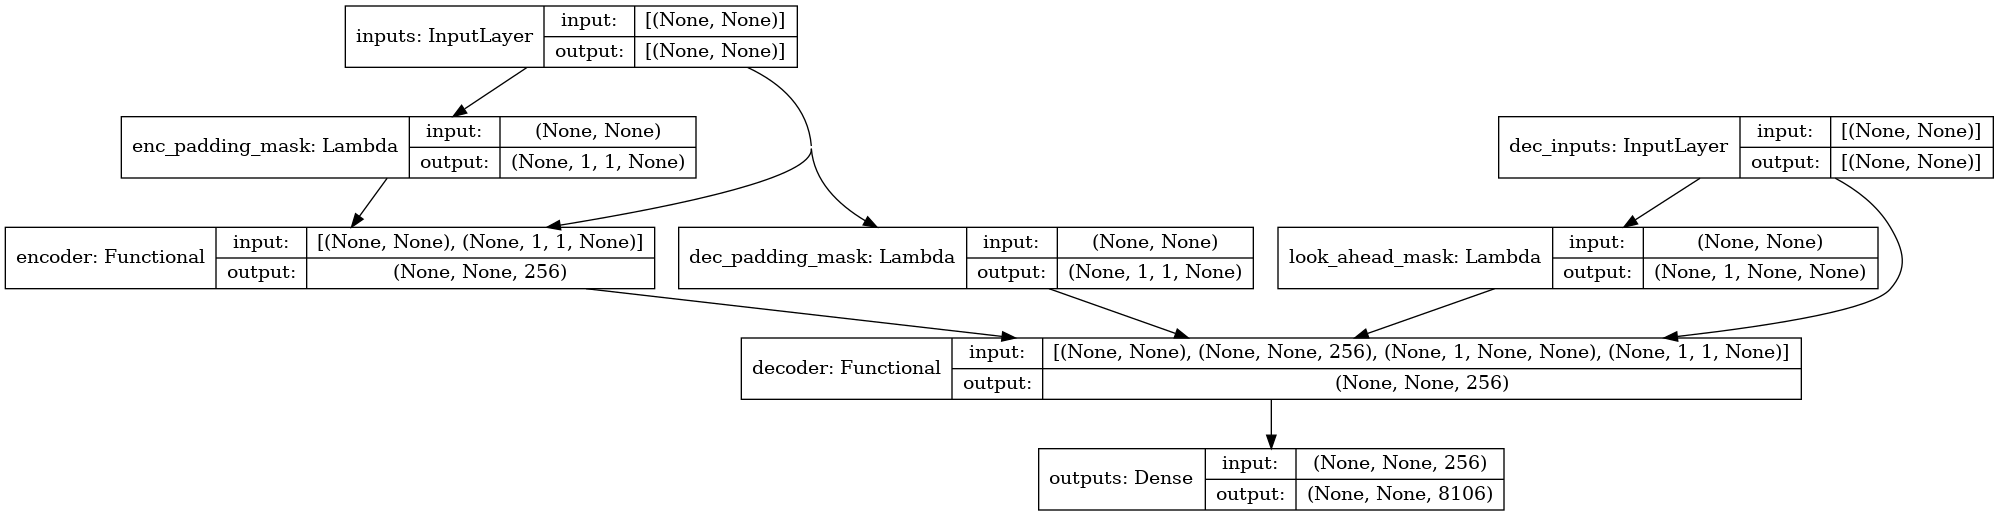

In [263]:
plot_model(model4_3, to_file='model4_3_shapes.png', show_shapes=True)

In [264]:
test_output4_3=[sentence_generation(i,model4_3) for i in test_sentences]
test_df["pred_4_3 A"]=test_output4_3

입력 : 피곤하다
출력 : 기분나쁘겠어요 .
------------------------------------------------------------
입력 : 오늘 뭐 먹지?
출력 : 색다른걸 드셔보세요 .
------------------------------------------------------------
입력 : 1년을 사귀었는데 헤어졌어
출력 : 먼저 다가가고 알아가야죠 .
------------------------------------------------------------
입력 : 남자친구가 연락이 없어
출력 : 먼저 연락을 해보세요 .
------------------------------------------------------------
입력 : 살쪘어
출력 : 식단조절을 .
------------------------------------------------------------
입력 : 짝사랑 중이야
출력 : 진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
------------------------------------------------------------
입력 : 회사가기 싫어
출력 : 월급날을 생각하며 참아보세요 .
------------------------------------------------------------
입력 : 놀러 가고 싶다
출력 : 주소 알려주세요 .
------------------------------------------------------------
입력 : 그 사람이 싫어
출력 : 가져보세요 .
------------------------------------------------------------
입력 : 언제까지 어깨춤을 추게할꺼야
출력 : 마음을 접은 걸까봐 두려운가요 .
------------------------------------------------------------
입력 : 아메리카노 마시고 싶다
출력 : 마시면 좋죠 .
-------------

In [265]:
test_df

,Q,pred1_A,pred2_1_A,pred_2_2 A,pred_2_3 A,pred_3_1 A,pred_3_2 A,pred_3_3 A,pred_4_1 A,pred_4_2 A,pred_4_3 A
0,피곤하다,혼자가 아니에요 .,아무 것도 안해도 괜찮아요 .,한가지만 게 몰라요 .,정말 잘 되길 .,서로 이해하고 배려해보세요 .,좋은 선택이길 바랄게요 .,살랑살랑 .,기다리면서 상처받지 마세요 .,이별이 좋은 친구를 뒀네요 .,기분나쁘겠어요 .
1,오늘 뭐 먹지?,색다른걸 드셔보세요 .,오늘은 예능이요 .,색다른걸 드셔보세요 .,맛있는 다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .,색다른걸 드셔보세요 .
2,1년을 사귀었는데 헤어졌어,오래 사귀셨네요 .,더 좋은 날들이 올 거예요 .,더 고 만나는 지도 아닐 거예요 .,더 더 더 더 더 더 더 더 더 더 더,더 좋은 날들이 올 거예요 .,먼저 만나보세요 .,더 좋은 날들이 올 거예요 .,먼저 연락을 해보는 건 어떨까요 .,더 오래 살아야 하니 가치관이 중요하겠어요 .,먼저 다가가고 알아가야죠 .
3,남자친구가 연락이 없어,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .,먼저 연락을 해보세요 .
4,살쪘어,제게 말씀해보세요 .,뭘 하든 잘 찾아보세요 .,뭘 힘들었고 있군요 .,요즘 한번쯤 시도해라고 볼 뿐이에요 .,항상 청결하게 관리하세요 .,식단조절을 .,식단조절을 .,뭘 입어도 멋져요 .,신기하네요 .,식단조절을 .
5,짝사랑 중이야,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,직접 물어보세요 .,진정으로 사랑한다면 직접 알아볼거예요 .,진정으로 사랑한다면 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도 사람도,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .,짝사랑은 시작과 끝을 자신이 결정할 수 있어요 .,진정으로 사랑한다면 사람도 당신의 사랑을 알아볼거예요 .
6,회사가기 싫어,가지 마세요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .,가족이 숨한 대해 좋을 같아요 .,운명일지도 모르겠어요 .,내가 결혼할 때가 결혼적령기예요 .,그것이 최선의 선택일거라 생각해요 .,우울한 이유에 대해 생각해보세요 .,우울한 이유에 대해 생각해보세요 .,월급날을 생각하며 참아보세요 .
7,놀러 가고 싶다,저도 주소 알려주세요 .,주소 알려주세요 .,제가 소 알려주세요 .,저도 알려주세요 .,저도 주기 어려울 거 같아요 .,저도 주당이에요 .,저도 데려가 주세요 .,저도 데려가 주세요 .,주소 알려주세요 .,주소 알려주세요 .
8,그 사람이 싫어,마음이 헛헛한가봐요 .,자신을 탓하지 마세요 .,제가 괜찮아질 거예요 .,세상은 더 의고 .,사랑은 변하고 사람은 안 변해요 .,제가 고민을 들어드릴게요 .,싫어하지 말아요 .,제가 있잖아요 .,슬픈 이야기네요 .,가져보세요 .
9,언제까지 어깨춤을 추게할꺼야,적당히 드세요 .,좋은 보내고 있나봐요 .,그분에게 중요해요 .,동사람에 열을 대해 .,얼떨할 거예요 .,생길거라 믿어요 .,오래오래 입으세요 .,사랑한 관계가 나아지지 않는다면 지칠지도 모르겠어요 .,자신의 건강만큼 쉬어야 할 같아요 .,마음을 접은 걸까봐 두려운가요 .


In [268]:
model_time

{'model1': 194.51784873008728,
 'model2_1': 273.5854609012604,
 'model2_2': 375.0685884952545,
 'model2_3': 470.8617558479309,
 'model3_1': 191.8471963405609,
 'model3_2': 200.26324105262756,
 'model3_3': 223.37795114517212,
 'model4_1': 145.92600417137146,
 'model4_2': 154.78830480575562,
 'model4_3': 181.3841769695282}